Moving on from *feature selection*, this chapter will cover *feature extraction*. There are three techniques covered in this chapter that will help to compress and summarize information within data sets by transforming it to a lower dimensional subspace:

* **Principal Component Analysis (PCA)** - unsupervised data compression
* **Linear Discriminant Analysis(LDA)** - supervised dimensionality reduction
* **kernel principal component analysis** - nonlinear dimensionality reduction

**Principal Component Analysis (PCA)** is a very common form of dimensionality reduction that creates a new subspace upon which data analysis can take place. PCA identifies patterns of correlation between features and uses these to find directions of maximal *variance*. Armed with this knowledge, one can construct a new orthogonal basis for the data spanned by normal vectors pointing in these directions of maximized variance. Doing so will necessarily lower the dimensionality of our dataset and minimize the *curse of dimensionality*

We have to construct a *d x k* mapping matrix **w** that maps an input vector **x** onto a *k*-dimensional subspace with fewer dimension than the original *d*-dimensional feature space.

$$\textbf{x} = [x_{1},x_{2},...,x_{d}], \textbf{x}\in\mathbb{R}^{\textbf{d}}$$

$$\textbf{xW}, \textbf{W}\in\mathbb{R}^{\textbf{dxk}}$$

$$\textbf{z} = [z_{1},z_{2},...,z_{k}], \textbf{z}\in\mathbb{R}^{\textbf{k}}$$

where, typically *k* << *d*.

We''l go through PCA now on the Wine dataset from last chapter.

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

First step: Standardize the data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

Step 2: Construct the covariance matrix for *d* features. Covariance between two features  $x_{j}$ and $x_{k}$ is defined mathematically as follows:

$$\sigma_{jk} = \frac{1}{n}\sum_{i=1}^{n}(x_{j}^{(i)} - \mu_{j})(x_{k}^{(i)} - \mu_{k})$$

We create a matrix from these values, then find the eigenvectors, which will be our principal components (directions of maximum variance) and eigenvalues (their magnitudes). Eigenvectors are defined as follows:

$$\Sigma\textbf{v} = \lambda\textbf{v}$$

where $\Sigma$ is our covariance matrix and **v** is an eigenvector with eigenvalue $\lambda$.

Luckily, all of this exists in NumPy.

In [3]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


Before we perform our dimensionality reduction, let's take a look at what this means by plotting the *variance explained ratio*, which is the fraction of an eigenvalues with the sum off all the eigenvalues.

$$\frac{\lambda_{j}}{\sum_{j=1}^{d}\lambda_{j}}$$

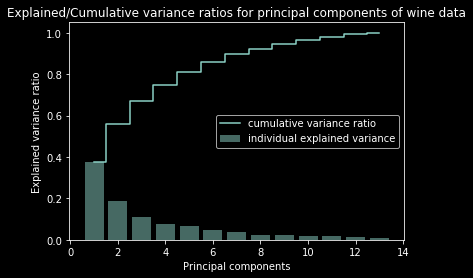

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.bar(range(1,14), var_exp, alpha =0.5, align='center',
        label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative variance ratio')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained/Cumulative variance ratios for principal components of wine data')
plt.legend(loc='best')
plt.show()

This shows that the first PCA accounts for nearly 40% of the variance in our data set.

Remember, PCA is an unsupervised method, meaning it ignores class labels entirely.

Step 3: Sort eigenpairs by decreasing order of eigenvalues.

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
               for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

Step 4: Build our transformation matrix based on the top 2 eigenvectors, which point in the directions the cumulatively account for 60% of the variance in our dataset.

In [6]:
w = np.hstack((eigen_pairs[0][1] [:, np.newaxis],
               eigen_pairs[1][1] [:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


Step 5: Transform our dataset using this matrix via the matrix dot product:

$$\textbf{X' = XW}$$

In [7]:
X_train_pca = X_train_std.dot(w)

Let's visualize our transformed data set.

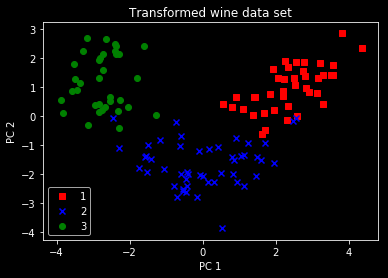

In [8]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

plt.style.use('dark_background')

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Transformed wine data set')
plt.legend(loc='lower left')
plt.show()

As it happens, scikit-learn has a PCA class to accomplish this. Let's do our analysis with it, train an LR model on the transformed data, and plot the decision regions.

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen','gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #plot class samples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X [y == c1, 0], y=X [y == c1, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers [idx], label=c1)
    

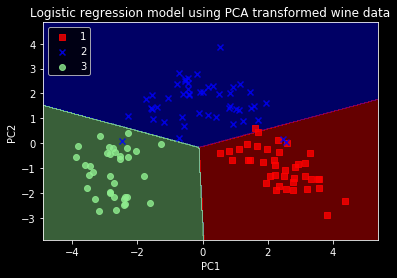

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
plt.style.use('dark_background')

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Logistic regression model using PCA transformed wine data')
plt.legend(loc='upper left')
plt.show()

This plot appears as an inverse of the one we got from our step-by-step approach because eigen vectors can be positive or negative depending on the solver, which is not a big deal.

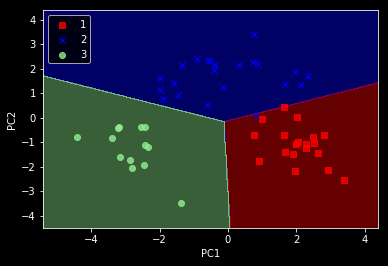

In [11]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()

We can also get explained variance ratio from the PCA class:

In [12]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

Moving from PCA, we land on **Linear Discriminant Analysis**, which can be thought of as the supervised analogue to PCA. In LDA, we try to find the subspace that maxzimizes class separability. It has 6 main steps:

* Standardize the d-dimensional dataset
* For each class, compute the d-dimensional mean vector
* Construct scatter matrices between-class ($\textbf{S}_{B}$) and within-class ($\textbf{S}_{w}$)
* Compute the eigenvectors/values of the matrix $\textbf{S}_{w}^{-1}\textbf{S}_{B}$
* Construct dxk transformation matrix **W** based on the k largest eigenvalues
* Project samples onto new feature subspace using **W**

We have to calculate mean vectors to build our scatter matrices. The mean vector $\textbf{m}_{i}$ stores mean feature value %\mu_{m}$ with respect to samples of class *i*.

$$\textbf{m}_{i} = \frac{1}{n_{i}}\sum_{x\in D_{i}}^{c}\textbf{x}_{m}$$

This results in three mean vectors, each included mean values for each feature, grouped by class.

In [13]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(
                 X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Let's define the scatter matrix:

$$\textbf{S}_{W} = \sum_{i=1}^{c}\textbf{S}_{i}$$

We sum up all the individual scatter matrices $\textbf{S}_{i}$ for each class *i*.

$$\textbf{S}_{i} = \sum_{x\in D_{i}}(\textbf{x} - \textbf{m}_{i})(\textbf{x} - \textbf{m}_{i})^{T}$$

In [14]:
d = 13 #number of features
S_W = np.zeros((d,d))

for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s'
         % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


We're assuming through calculating the scatter matrices that class labels in the training set are uniformly distributed.

In [15]:
print('Class label distribution %s'
         % np.bincount(y_train)[1:])

Class label distribution [40 49 35]


But they're not. We're violating a basic assumption of LDA. If we scale our scatter matrices by dividing by the number of class samples, we get back the equation for computing the covariance matrix.

*The covariance matrix is a normalized version of the scatter matrix*.

In [16]:
d = 13 #number of features
S_W = np.zeros((d,d))

for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: %sx%s'
         % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Now we have to compute the between-class matrix

$$\textbf{S}_{\textbf{B}} = \sum_{i=1}^{\textbf{c}}N_{i}(\textbf{m}_{i}-\textbf{m})(\textbf{m}_{i}-\textbf{m})^{T}$$

where **m** is the overall mean.

In [17]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 #number of features
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s'
         % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


Now, we solve the generalized eigenvalue problem of $\textbf{S}_{w}^{-1}\textbf{S}_{\textbf{B}}$.

In [18]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [19]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
                    for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                        key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order: \n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order: 

452.721581245
156.43636122
1.05646703435e-13
3.99641853702e-14
3.40923565291e-14
2.84217094304e-14
1.4793035293e-14
1.4793035293e-14
1.3494134504e-14
1.3494134504e-14
6.49105985585e-15
6.49105985585e-15
2.65581215704e-15


Let's plot the information we've gleaned from this analysis in terms of *discriminability*.

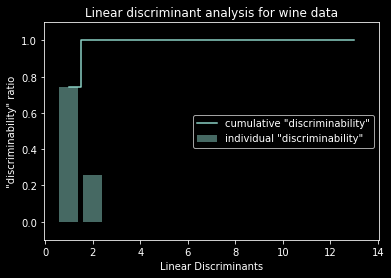

In [20]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.style.use('dark_background')
plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.title('Linear discriminant analysis for wine data')
plt.show()

The first two eigenvectors are capturing 100% of the useful data in the Wine dataset. We have to construct our transformation matrix now.

In [21]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


Now let's use this matrix **W** to transform our matrix.

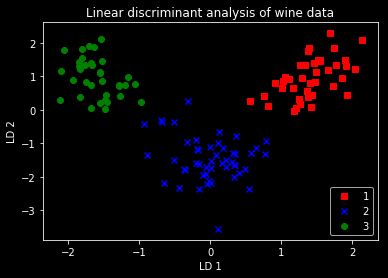

In [24]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

plt.style.use('dark_background')

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0]*(-1),
                X_train_lda[y_train==l, 1]*(-1),
                c=c, label=l, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.title('Linear discriminant analysis of wine data')
plt.show()



We have attained linear separability for this dataset.

As we'd expect by now, this is way easier in scikit-learn.

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

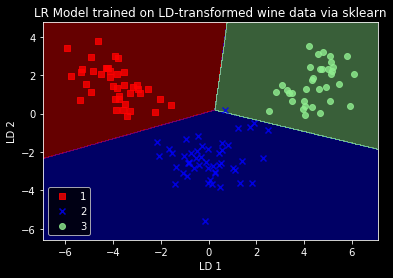

In [29]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plt.style.use('dark_background')

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title('LR Model trained on LD-transformed wine data via sklearn')
plt.show()


We could probably prevent the single misclassification from the above model by manipulating the regularization strength, but let's see how the model performs against the test set first.

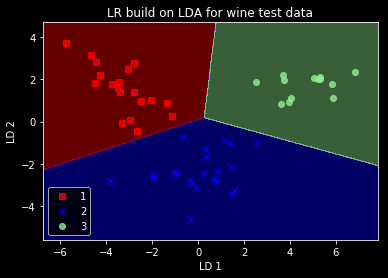

In [30]:
X_test_lda = lda.transform(X_test_std)

plt.style.use('dark_background')

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title('LR built on LDA for wine test data')
plt.show()

The next section in the book is on kernel principal component, which is the nonlinear version of PCA discussed earlier. It is **very** math intensive, so I won't be writing it all out verbosely in this notebook. 

The idea is similar but opposite to that of PCA. We can tackle nonlinear problems by finding a function $\phi$ that maps a *d*-dimensional dataset to a larger *k*-dimensional dataset.

The idea of a **kernel function** *k* is that you needn't explicitly calculate the eigenvectors of the covariance matrix for a nonlinear problem. In layman's terms, *it's a function that calculates the dot product between vectors*, and when we apply the function, we get back our input transformed already. 

If you're curious to go through the math yourself, the discussion of deriving the kernel eigenvalue problem and the definition of the kernel matrix can be found in Raschka pp. 149-151.

There are three steps to implementing kernel PCA:

1. Compute the kernel (similarity) matrix *k*:
        
  $$k(\textbf{x}^{(i)}, \textbf{x}^{(j)}) = exp(-\gamma||\textbf{x}^{(i)} - \textbf{x}^{(j)}||^{2}$$
  
2. Center the kernel matrix. This step is necessary because our data will be standardized and there's no guarantee that the feature space we are transforming our data to will be centered at 0.

$$\textbf{K}' = \textbf{K} - l_{n}\textbf{K} - \textbf{K}l_{n} + l_{n}\textbf{K}l_{n}$$
$$\text{where $l_{n}$ is an nxn matrix (same as $\textbf{K}$) where all values are equal to $\frac{1}{n}$}$$
    
$\text{3.}$ Collect the top *k* eigenvectors based on eigenvalues. In contrast with PCA from before, what we get back from this is the projection of our dataset onto the new eigenbasis.

Implementation of the kernel PCA follows below and utilizes some tricks in NumPy and SciPy.

Note that 

In [31]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [32]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.
    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
        Tuning parameter of the RBF kernel
        
    n_components: int
        Number of principal components to return
        
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
        Projected dataset
    """
    
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')
    
    # Convert the pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)
    
    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    #Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))
    
    return X_pc

Specifying the hyperparameter $\gamma$ requires experimentation. Chapter 6 has some methods that will be helpful.

Let's use our RBF kernel PCA function to transform a data consisting of half-moon shapes.

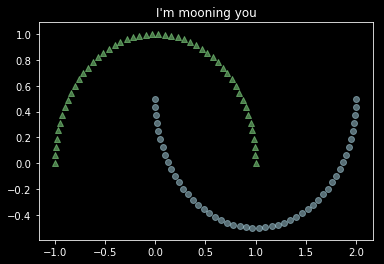

In [35]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.style.use('dark_background')

plt.scatter(X[y==0, 0], X[y==0, 1],
            color='lightgreen', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
            color='lightblue', marker='o', alpha=0.5)
plt.title("I'm mooning you")
plt.show()

It's clear that these are not linearly separable.  If we project it onto its principal components via normal PCA:

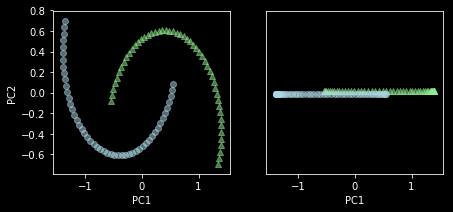

In [37]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='lightgreen', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='lightblue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1)) + 0.02,
              color='lightgreen', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1)) - 0.02,
              color='lightblue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

The second plot only shows the first principal component to illustrate the degree of overlap. So, let's try our kernel PCA function.

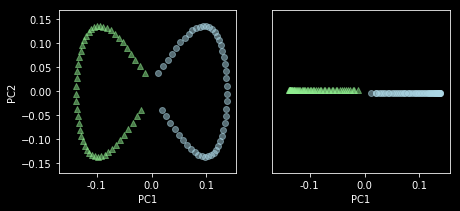

In [45]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='lightgreen', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='lightblue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1)) + 0.02,
              color='lightgreen', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1)) - 0.02,
              color='lightblue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.show()

So we have achieved linear separability. Luckily, we knew gamma. Below are some examples of other gamma values that would result in issues in training a model.

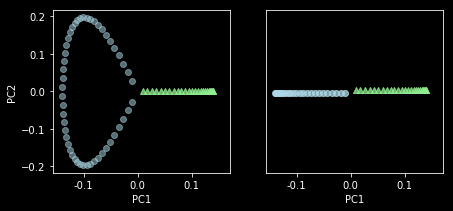

In [48]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=150, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='lightgreen', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='lightblue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1)) + 0.02,
              color='lightgreen', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1)) - 0.02,
              color='lightblue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.show()

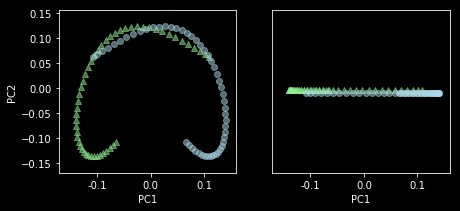

In [49]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=1.5, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='lightgreen', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='lightblue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1)) + 0.02,
              color='lightgreen', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1)) - 0.02,
              color='lightblue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.show()

We'll do another dataset: concentric circles.

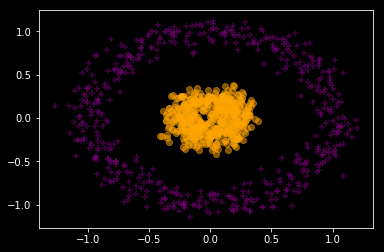

In [52]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000,
                    random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y==0, 0], X[y==0, 1],
            color='purple', marker='+', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
            color='orange', marker='o', alpha=0.5)
plt.show()

Using standard PCA:

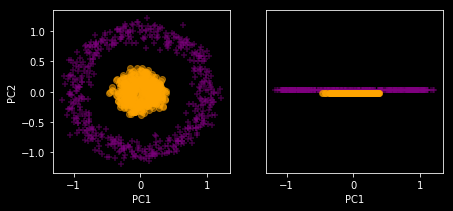

In [56]:

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='purple', marker='+', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='orange', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1)) + 0.02,
              color='purple', marker='+', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1)) - 0.02,
              color='orange', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

Again we see sklearn's PCA has failed us. With a value for $\gamma$ already determined, let's check out the RBF kernel PCA-implemented version:

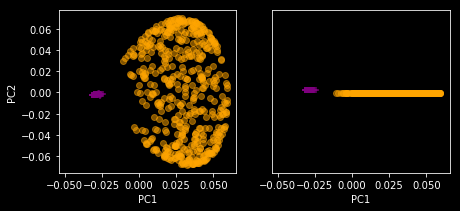

In [57]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='purple', marker='+', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='orange', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02,
              color='purple', marker='+', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02,
              color='orange', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.show()

Once again, we've managed to separate the data.

Now, for some bad gammas:

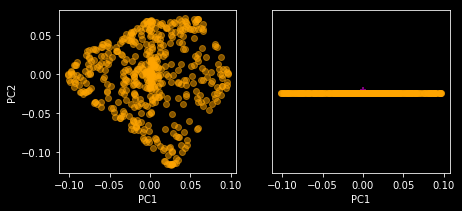

In [58]:
X_kpca = rbf_kernel_pca(X, gamma=150, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='purple', marker='+', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='orange', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02,
              color='purple', marker='+', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02,
              color='orange', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.show()

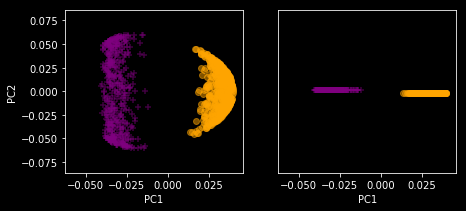

In [59]:
X_kpca = rbf_kernel_pca(X, gamma=1.5, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='purple', marker='+', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='orange', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02,
              color='purple', marker='+', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02,
              color='orange', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.show()

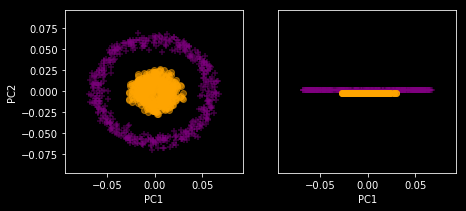

In [60]:
X_kpca = rbf_kernel_pca(X, gamma=.15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='purple', marker='+', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='orange', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02,
              color='purple', marker='+', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02,
              color='orange', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.show()

Looks like $\gamma=1.5$ would have worked well too, but obviously the purple series could be contracted even tighter.

We will now modify the coding of our rbf_kernel_pca function to allow for mapping other datasets onto the subspace we obtain from the kernel trick. We have to return eigenvalues for normalizing our eigenvectors.

In [61]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.
    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
        Tuning parameter of the RBF kernel
        
    n_components: int
        Number of principal components to return
        
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
        Projected dataset
    """
    
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')
    
    # Convert the pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)
    
    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))
    
    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]
    
    return alphas, lambdas

We'll create a new half-moon dataset and project it onto a 1D space using this new kernel PCA function.

In [62]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

x_new = X[25]
x_new

array([ 1.8713,  0.0093])

In [63]:
x_proj = alphas[25] # original projection
x_proj

array([ 0.0788])

In [64]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum(
                    (x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

Using this function project_x, we should be able to project new data samples. Let's visualize to make sure:

In [65]:
x_reproj = project_x(x_new, X,
                     gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([ 0.0788])

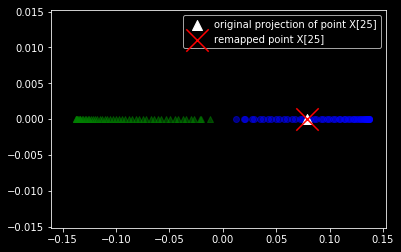

In [68]:
plt.scatter(alphas[y==0, 0], np.zeros((50)),
            color='green', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='white',
            label='original projection of point X[25]',
            marker='^', s=100)
plt.scatter(x_reproj, 0, color='red',
            label ='remapped point X[25]',
            marker='x', s=500)

plt.legend(scatterpoints=1)
plt.show()

Thus, we mapped the new sample onto the first principal component correctly.

Again, scikit-learn has a much easier implementation of this:

In [69]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2,
                        kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

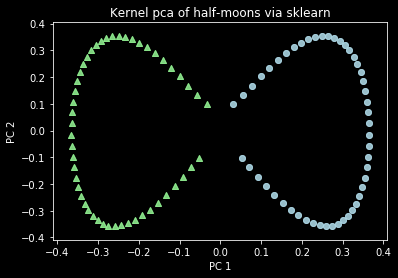

In [72]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca [y==0, 1],
            color='lightgreen', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
            color='lightblue', marker='o', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Kernel pca of half-moons via sklearn')
plt.show()

The following topics were covered in this chapter:
* Principal Component Analysis
* Linear Discriminant Analysis
* Kernel Principal Component Analysis

All of these were done from scratch, then using scikit-learn's implementations.

As we mentioned several times during this chapter, fine-tuning hyperparameters is an important skill that will be covered in the next chapter.